In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from tqdm import trange
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [1]:
# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 300 #256 # what is the maximum context length for predictions?
max_iters = 120000
eval_interval = 1000
learning_rate = 1e-3 #3e-4
eval_iters = 200
n_embd = 256 #384
n_head = 4  #6    # 10 for saved withoput RoPE
n_layer = 6   # 10 for saved withoput RoPE
dropout = 0.3
# head_size = n_embd // n_head   ==> most be even number to be able to apply RoPS

In [3]:
with open('russian_comments_corrected-2.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# tokenizer

In [42]:
from collections import Counter, deque
from functools import lru_cache
import json

In [43]:
class BPETokenizerSimple:
    def __init__(self):
        # Maps token_id to token_str (e.g., {11246: "some"})
        self.vocab = {}
        # Maps token_str to token_id (e.g., {"some": 11246})
        self.inverse_vocab = {}
        # Dictionary of BPE merges: {(token_id1, token_id2): merged_token_id}
        self.bpe_merges = {}

        # For the official OpenAI GPT-2 merges, use a rank dict:
        #  of form {(string_A, string_B): rank}, where lower rank = higher priority
        self.bpe_ranks = {}

    def train(self, text, vocab_size, allowed_special={"<|endoftext|>"}):
        """
        Train the BPE tokenizer from scratch.

        Args:
            text (str): The training text.
            vocab_size (int): The desired vocabulary size.
            allowed_special (set): A set of special tokens to include.
        """

        # Preprocess: Replace spaces with "Ġ"
        # Note that Ġ is a particularity of the GPT-2 BPE implementation
        # E.g., "Hello world" might be tokenized as ["Hello", "Ġworld"]
        processed_text = []
        for i, char in enumerate(text):
            if char == " " and i != 0:
                processed_text.append("Ġ")
            if char != " ":
                processed_text.append(char)
        processed_text = "".join(processed_text)

        # Initialize vocab with unique characters, including "Ġ" if present
        # Start with the first 256 ASCII characters
        unique_chars = [chr(i) for i in range(256)]
        unique_chars.extend(
            char for char in sorted(set(processed_text))
            if char not in unique_chars
        )
        if "Ġ" not in unique_chars:
            unique_chars.append("Ġ")

        self.vocab = {i: char for i, char in enumerate(unique_chars)}
        self.inverse_vocab = {char: i for i, char in self.vocab.items()}

        # Add allowed special tokens
        if allowed_special:
            for token in allowed_special:
                if token not in self.inverse_vocab:
                    new_id = len(self.vocab)
                    self.vocab[new_id] = token
                    self.inverse_vocab[token] = new_id

        # Tokenize the processed_text into token IDs
        token_ids = [self.inverse_vocab[char] for char in processed_text]

        # BPE steps 1-3: Repeatedly find and replace frequent pairs
        for new_id in range(len(self.vocab), vocab_size):
            pair_id = self.find_freq_pair(token_ids, mode="most")
            if pair_id is None:
                break
            token_ids = self.replace_pair(token_ids, pair_id, new_id)
            self.bpe_merges[pair_id] = new_id

        # Build the vocabulary with merged tokens
        for (p0, p1), new_id in self.bpe_merges.items():
            merged_token = self.vocab[p0] + self.vocab[p1]
            self.vocab[new_id] = merged_token
            self.inverse_vocab[merged_token] = new_id


    def encode(self, text, allowed_special=None):
        """
        Encode the input text into a list of token IDs, with tiktoken-style handling of special tokens.
    
        Args:
            text (str): The input text to encode.
            allowed_special (set or None): Special tokens to allow passthrough. If None, special handling is disabled.
    
        Returns:
            List of token IDs.
        """
        import re
    
        token_ids = []
    
        # If special token handling is enabled
        if allowed_special is not None and len(allowed_special) > 0:
            # Build regex to match allowed special tokens
            special_pattern = (
                "(" + "|".join(re.escape(tok) for tok in sorted(allowed_special, key=len, reverse=True)) + ")"
            )
    
            last_index = 0
            for match in re.finditer(special_pattern, text):
                prefix = text[last_index:match.start()]
                token_ids.extend(self.encode(prefix, allowed_special=None))  # Encode prefix without special handling
    
                special_token = match.group(0)
                if special_token in self.inverse_vocab:
                    token_ids.append(self.inverse_vocab[special_token])
                else:
                    raise ValueError(f"Special token {special_token} not found in vocabulary.")
                last_index = match.end()
    
            text = text[last_index:]  # Remaining part to process normally
    
            # Check if any disallowed special tokens are in the remainder
            disallowed = [
                tok for tok in self.inverse_vocab
                if tok.startswith("<|") and tok.endswith("|>") and tok in text and tok not in allowed_special
            ]
            if disallowed:
                raise ValueError(f"Disallowed special tokens encountered in text: {disallowed}")
    
        # If no special tokens, or remaining text after special token split:
        tokens = []
        lines = text.split("\n")
        for i, line in enumerate(lines):
            if i > 0:
                tokens.append("\n")
            words = line.split()
            for j, word in enumerate(words):
                if j == 0 and i > 0:
                    tokens.append("Ġ" + word)
                elif j == 0:
                    tokens.append(word)
                else:
                    tokens.append("Ġ" + word)
    
        for token in tokens:
            if token in self.inverse_vocab:
                token_ids.append(self.inverse_vocab[token])
            else:
                token_ids.extend(self.tokenize_with_bpe(token))
    
        return token_ids

    def tokenize_with_bpe(self, token):
        """
        Tokenize a single token using BPE merges.

        Args:
            token (str): The token to tokenize.

        Returns:
            List[int]: The list of token IDs after applying BPE.
        """
        # Tokenize the token into individual characters (as initial token IDs)
        token_ids = [self.inverse_vocab.get(char, None) for char in token]
        if None in token_ids:
            missing_chars = [char for char, tid in zip(token, token_ids) if tid is None]
            raise ValueError(f"Characters not found in vocab: {missing_chars}")

        # If we haven't loaded OpenAI's GPT-2 merges, use my approach
        if not self.bpe_ranks:
            can_merge = True
            while can_merge and len(token_ids) > 1:
                can_merge = False
                new_tokens = []
                i = 0
                while i < len(token_ids) - 1:
                    pair = (token_ids[i], token_ids[i + 1])
                    if pair in self.bpe_merges:
                        merged_token_id = self.bpe_merges[pair]
                        new_tokens.append(merged_token_id)
                        # Uncomment for educational purposes:
                        # print(f"Merged pair {pair} -> {merged_token_id} ('{self.vocab[merged_token_id]}')")
                        i += 2  # Skip the next token as it's merged
                        can_merge = True
                    else:
                        new_tokens.append(token_ids[i])
                        i += 1
                if i < len(token_ids):
                    new_tokens.append(token_ids[i])
                token_ids = new_tokens
            return token_ids

        # Otherwise, do GPT-2-style merging with the ranks:
        # 1) Convert token_ids back to string "symbols" for each ID
        symbols = [self.vocab[id_num] for id_num in token_ids]

        # Repeatedly merge all occurrences of the lowest-rank pair
        while True:
            # Collect all adjacent pairs
            pairs = set(zip(symbols, symbols[1:]))
            if not pairs:
                break

            # Find the pair with the best (lowest) rank
            min_rank = float("inf")
            bigram = None
            for p in pairs:
                r = self.bpe_ranks.get(p, float("inf"))
                if r < min_rank:
                    min_rank = r
                    bigram = p

            # If no valid ranked pair is present, we're done
            if bigram is None or bigram not in self.bpe_ranks:
                break

            # Merge all occurrences of that pair
            first, second = bigram
            new_symbols = []
            i = 0
            while i < len(symbols):
                # If we see (first, second) at position i, merge them
                if i < len(symbols) - 1 and symbols[i] == first and symbols[i+1] == second:
                    new_symbols.append(first + second)  # merged symbol
                    i += 2
                else:
                    new_symbols.append(symbols[i])
                    i += 1
            symbols = new_symbols

            if len(symbols) == 1:
                break

        # Finally, convert merged symbols back to IDs
        merged_ids = [self.inverse_vocab[sym] for sym in symbols]
        return merged_ids

    def decode(self, token_ids):
        """
        Decode a list of token IDs back into a string.

        Args:
            token_ids (List[int]): The list of token IDs to decode.

        Returns:
            str: The decoded string.
        """
        decoded_string = ""
        for i, token_id in enumerate(token_ids):
            if token_id not in self.vocab:
                raise ValueError(f"Token ID {token_id} not found in vocab.")
            token = self.vocab[token_id]
            if token == "\n":
                if decoded_string and not decoded_string.endswith(" "):
                    decoded_string += " "  # Add space if not present before a newline
                decoded_string += token
            elif token.startswith("Ġ"):
                decoded_string += " " + token[1:]
            else:
                decoded_string += token
        return decoded_string

    def save_vocab_and_merges(self, vocab_path, bpe_merges_path):
        """
        Save the vocabulary and BPE merges to JSON files.

        Args:
            vocab_path (str): Path to save the vocabulary.
            bpe_merges_path (str): Path to save the BPE merges.
        """
        # Save vocabulary
        with open(vocab_path, "w", encoding="utf-8") as file:
            json.dump(self.vocab, file, ensure_ascii=False, indent=2)

        # Save BPE merges as a list of dictionaries
        with open(bpe_merges_path, "w", encoding="utf-8") as file:
            merges_list = [{"pair": list(pair), "new_id": new_id}
                           for pair, new_id in self.bpe_merges.items()]
            json.dump(merges_list, file, ensure_ascii=False, indent=2)

    def load_vocab_and_merges(self, vocab_path, bpe_merges_path):
        """
        Load the vocabulary and BPE merges from JSON files.

        Args:
            vocab_path (str): Path to the vocabulary file.
            bpe_merges_path (str): Path to the BPE merges file.
        """
        # Load vocabulary
        with open(vocab_path, "r", encoding="utf-8") as file:
            loaded_vocab = json.load(file)
            self.vocab = {int(k): v for k, v in loaded_vocab.items()}
            self.inverse_vocab = {v: int(k) for k, v in loaded_vocab.items()}

        # Load BPE merges
        with open(bpe_merges_path, "r", encoding="utf-8") as file:
            merges_list = json.load(file)
            for merge in merges_list:
                pair = tuple(merge["pair"])
                new_id = merge["new_id"]
                self.bpe_merges[pair] = new_id

    @lru_cache(maxsize=None)
    def get_special_token_id(self, token):
        return self.inverse_vocab.get(token, None)

    @staticmethod
    def find_freq_pair(token_ids, mode="most"):
        pairs = Counter(zip(token_ids, token_ids[1:]))

        if not pairs:
            return None

        if mode == "most":
            return max(pairs.items(), key=lambda x: x[1])[0]
        elif mode == "least":
            return min(pairs.items(), key=lambda x: x[1])[0]
        else:
            raise ValueError("Invalid mode. Choose 'most' or 'least'.")

    @staticmethod
    def replace_pair(token_ids, pair_id, new_id):
        dq = deque(token_ids)
        replaced = []

        while dq:
            current = dq.popleft()
            if dq and (current, dq[0]) == pair_id:
                replaced.append(new_id)
                # Remove the 2nd token of the pair, 1st was already removed
                dq.popleft()
            else:
                replaced.append(current)

        return replaced

In [44]:
tokenizer = BPETokenizerSimple()

In [45]:
tokenizer.train(text, vocab_size=3000, allowed_special={"<|endoftext|>"})

In [14]:
print(len(tokenizer.vocab))
print(len(tokenizer.bpe_merges))

6000
5318


In [46]:
# Save trained tokenizer
tokenizer.save_vocab_and_merges(vocab_path="vocab_3000_ru_final.json", bpe_merges_path="bpe_merges_3000_ru_final.txt")
#tokenizer.save_vocab_and_merges(vocab_path="vocab_6000_ru_final.json", bpe_merges_path="bpe_merges_6000_ru_final.txt")

In [8]:
# Load tokenizer
tokenizer = BPETokenizerSimple()
tokenizer.load_vocab_and_merges(vocab_path="vocab_6000_ru_final.json", bpe_merges_path="bpe_merges_6000_ru_final.txt")

In [47]:
data = torch.tensor(tokenizer.encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

# Model

In [49]:
class RotaryPositionalEmbedding(nn.Module):
    def __init__(self, dim, max_seq_len=2048):
        super().__init__()
        inv_freq = 1. / (10000 ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer("inv_freq", inv_freq)
        self.max_seq_len = max_seq_len
        self.cache = {}

    def _get_cos_sin(self, seq_len, device):    # seq_len = 256 (block_size)
        if seq_len in self.cache:
            return self.cache[seq_len] 

        t = torch.arange(seq_len, device=device, dtype=torch.float32)
        freqs = torch.einsum('i,j->ij', t, self.inv_freq)
        emb = torch.cat((freqs, freqs), dim=-1)
        cos_emb = emb.cos()
        sin_emb = emb.sin()


        # Cache for efficiency
        self.cache[seq_len] = (cos_emb, sin_emb)
        return cos_emb, sin_emb,

    def forward(self, x, seq_len=None):
        if seq_len is None:
            seq_len = x.shape[1]
        dim_pairs = x.shape[2] // 2
        cos_emb, sin_emb = self._get_cos_sin(seq_len, x.device)

        cos_vals = cos_emb.view(1, seq_len, dim_pairs, 2)
        sin_vals = sin_emb.view(1, seq_len, dim_pairs, 2)

        B, T, C = x.shape

        x_reshaped = x.view(batch_size, seq_len, dim_pairs, 2)   # (B, T, C/2, 2)

        x_rotated_first_half = x_reshaped[..., 0] * cos_vals[..., 0] - x_reshaped[..., 1] * sin_vals[..., 0]
        x_rotated_second_half = x_reshaped[..., 0] * sin_vals[..., 1] + x_reshaped[..., 1] * cos_vals[..., 1]
        x_rotated = torch.stack((x_rotated_first_half, x_rotated_second_half), dim=-1)
        x_rotated = x_rotated.view(B, T, C)

        return x_rotated

In [50]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [51]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.rope = RotaryPositionalEmbedding(head_size)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = batch_siz, block_size, n_embd
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # Apply RoPE to queries and keys
        q = self.rope(q)
        k = self.rope(k)


        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

In [52]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

In [53]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),    
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

In [54]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [55]:
class TransformerLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :] # becomes (B, C)
            probs = F.softmax(logits, dim=-1) # (B, C)
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [56]:
vocab_size = len(tokenizer.vocab)

In [57]:
model = TransformerLanguageModel().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

6.350264 M parameters


In [73]:
#train_loss, val_loss = [], []
for iter in trange((max_iters)):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        train_loss.append(losses['train'])
        val_loss.append(losses['val'])
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

  0%|                                                                             | 1/20000 [00:06<35:43:32,  6.43s/it]

step 0: train loss 1.3438, val loss 1.7857


  5%|███▊                                                                       | 1001/20000 [01:04<4:27:04,  1.19it/s]

step 1000: train loss 1.3477, val loss 1.7819


 10%|███████▌                                                                   | 2001/20000 [02:01<4:47:12,  1.04it/s]

step 2000: train loss 1.3453, val loss 1.7812


 15%|███████████▎                                                               | 3002/20000 [02:59<3:13:07,  1.47it/s]

step 3000: train loss 1.3481, val loss 1.7866


 20%|███████████████                                                            | 4004/20000 [03:57<2:21:22,  1.89it/s]

step 4000: train loss 1.3384, val loss 1.7818


 25%|██████████████████▊                                                        | 5001/20000 [04:54<3:43:26,  1.12it/s]

step 5000: train loss 1.3438, val loss 1.7782


 30%|██████████████████████▌                                                    | 6003/20000 [05:52<2:43:59,  1.42it/s]

step 6000: train loss 1.3396, val loss 1.7814


 35%|██████████████████████████▎                                                | 7003/20000 [06:50<2:46:54,  1.30it/s]

step 7000: train loss 1.3394, val loss 1.7708


 40%|██████████████████████████████                                             | 8001/20000 [07:47<2:12:34,  1.51it/s]

step 8000: train loss 1.3364, val loss 1.7877


 45%|█████████████████████████████████▊                                         | 9002/20000 [08:46<2:50:12,  1.08it/s]

step 9000: train loss 1.3368, val loss 1.7796


 50%|█████████████████████████████████████                                     | 10002/20000 [09:42<1:48:48,  1.53it/s]

step 10000: train loss 1.3367, val loss 1.7824


 55%|████████████████████████████████████████▋                                 | 11002/20000 [10:40<2:11:44,  1.14it/s]

step 11000: train loss 1.3266, val loss 1.7810


 60%|████████████████████████████████████████████▍                             | 12002/20000 [11:38<1:57:08,  1.14it/s]

step 12000: train loss 1.3321, val loss 1.7684


 65%|████████████████████████████████████████████████                          | 13003/20000 [12:36<1:20:47,  1.44it/s]

step 13000: train loss 1.3263, val loss 1.7920


 70%|█████████████████████████████████████████████████████▏                      | 14004/20000 [13:33<52:31,  1.90it/s]

step 14000: train loss 1.3286, val loss 1.7795


 75%|█████████████████████████████████████████████████████████                   | 15001/20000 [14:29<55:41,  1.50it/s]

step 15000: train loss 1.3267, val loss 1.7895


 80%|███████████████████████████████████████████████████████████▏              | 16001/20000 [15:27<1:05:19,  1.02it/s]

step 16000: train loss 1.3255, val loss 1.7843


 85%|████████████████████████████████████████████████████████████████▌           | 17001/20000 [16:24<40:39,  1.23it/s]

step 17000: train loss 1.3226, val loss 1.7845


 90%|████████████████████████████████████████████████████████████████████▍       | 18003/20000 [17:22<18:25,  1.81it/s]

step 18000: train loss 1.3219, val loss 1.7845


 95%|████████████████████████████████████████████████████████████████████████▏   | 19003/20000 [18:23<11:48,  1.41it/s]

step 19000: train loss 1.3248, val loss 1.7709


100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [19:19<00:00, 17.25it/s]

step 19999: train loss 1.3181, val loss 1.7874


In [75]:
context = torch.zeros((batch_size, block_size), dtype=torch.long, device=device)
print(tokenizer.decode(model.generate(context, max_new_tokens=500)[0].tolist()))

                                                                                                                                                                                                                                                                                                             Алум-речувство этого во-мраморно профессионализмой в стиле сети. Мно гостей познакомится с официантами о храннике,. 
 Ужасно аведение (хоть и я, но льше не сторонку тут облачко) в программу. Не случилось, чтоб теперь светить кно выдается веранда со своими пригласимонамзами. Один чудо сразу за чётко, предпочтения игрой действительно истекшие и. 
 Очень приятно место! 
 Повело на вкусный завтрак у дома: теперь всегда стоит подно общаться с первого раза рождения) 
 Неплохая кухня, большой выбор блюд. Персонал - всегда прислушиваются и попахти бокалы раки хватает. 
 Сегодня они покорили, видимо уютный хамит отлично пива и отменные в обламаете в осно м дома:!!! 
 Пельгийские фильмы, низкий ценни

In [66]:
import matplotlib.pyplot as plt
def plot_results(losses, accuracies, title1, title2):
    # Plot the loss
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(losses) + 1), losses)
    plt.title(title1)
    plt.xlabel('Epochs (x1000)')
    plt.ylabel('Loss')
    plt.grid(True)

    # Plot the accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(accuracies) + 1), accuracies)
    plt.title(title2)
    plt.xlabel('Epochs (x1000)')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

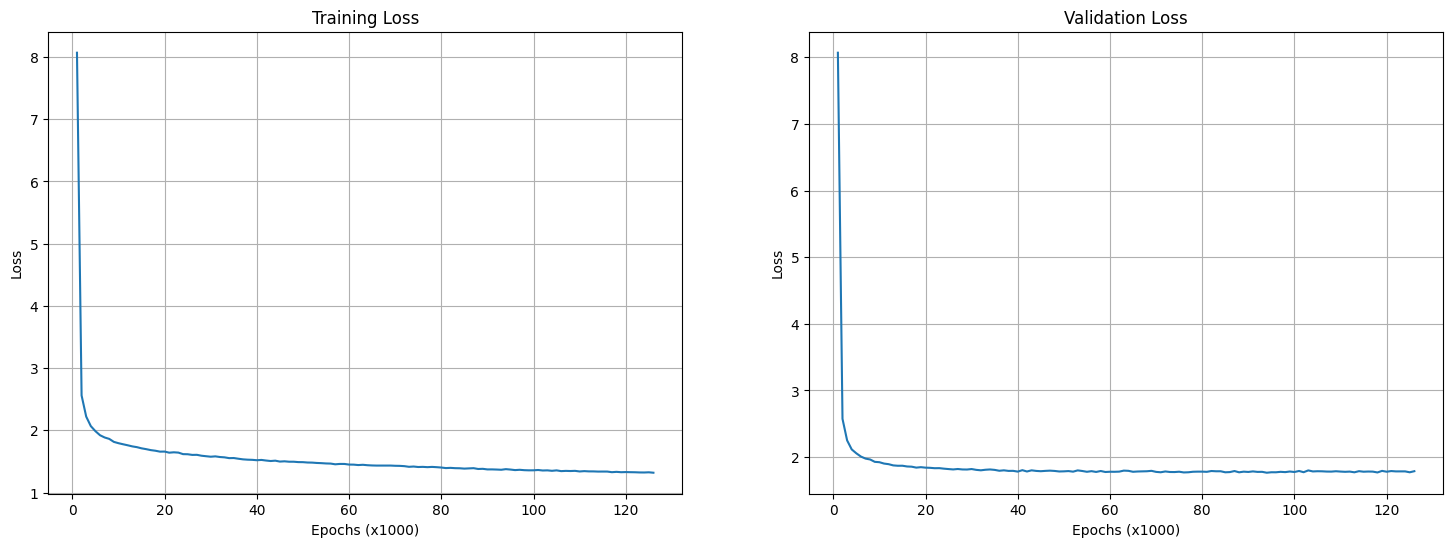

In [74]:
plot_results(train_loss, val_loss, "Training Loss", "Validation Loss")

In [78]:
#PATH = "transformer_model_RoPE_book.pt"
PATH = 'transformer_model_comment_final.pt'
# Save the model's state_dict
torch.save(model.state_dict(), PATH)

print(f"Model saved successfully to {PATH}")

Model saved successfully to transformer_model_comment_final.pt


In [ ]:
PATH = 'transformer_model_comment_final.pt'
model = TransformerLanguageModel().to(device) # Create a new instance of the same model class
model.load_state_dict(torch.load(PATH)) #, map_location='cpu'))
#loaded_model.eval() # Set the model to evaluation mode (important for inference)

optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)

print("Model loaded successfully.")